# Testing parameter retrieval using finite time window InSAR acquisition for a future Enceladus mission
___
Rishav Mallick & Mark Simons
___

The general displacement observation of an unwrapped InSAR measurement is given by   
$$\Delta u_{los}^{a-b} = (\mathbf{u}_a - \mathbf{u}_b).\hat{\mathbf{l}} + b^{a-b} + \epsilon^{a-b}$$

where $b^{a-b}$ is the error associated with errors in perpendicular baseline while $\epsilon^{a-b}$ refers to other errors. The displacements can arise from a number of different processes, but in this case we are interested in a time series of the form:

$$ \mathbf{u}(\mathbf{r},t) = \mathbf{u}_0(\mathbf{r}) + \mathbf{v}(\mathbf{r})t + \mathbf{A}(\mathbf{r})\sin\left(\omega t + \pmb{\phi}\right)$$

where $\mathbf{v},\omega,\pmb{\phi}$ are the secular velocity, oscillatory frequency and phase shift of the dominant sinusoid at the observation point $\mathbf{r}$.

The line-of-sight vector can be calculated using the flight azimuth and look angle as follows: 

In [37]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors

la = np.deg2rad(50) # look angle in degrees
az = np.deg2rad(20) # flight azimuth

los_vec = np.array([np.cos(la) * np.cos(az), np.cos(la) * np.sin(az), -np.sin(la)])


### Error model for imperfect DEM and perpendicular baselines

The error $b^{a-b}$ can be estimated using the following relationship:
$$ b^{a-b} = \frac{B_p^{a-b}}{r_0\sin\theta_0}\delta h $$
where $B_p^{a-b}$ is the perpendicular baseline for the 2 acquisitions, $r_0,\sin\theta_0$ are the range and incidence angle. $\delta h$ is the error associated with the topographic phase which arises from using an imperfect DEM.

### Enceladus application
For Enceladus, the orbital period around Saturn is the same as the tidal period = 33 hours, while the SAR mission is planned to orbit the moon every 29.5 hours. This means that it will be possible to estimate the amplitude and phase of the sinusoidal forcing term from the SAR time series. However, we would like to know how much acquisition will it require for us to do this robustly, given the typical noise in the data?

## Define Parameters 

In [38]:
# Define all parameters used in this notebook

# Enceladus parameters
A = np.array([1,0.2,3]) # periodic displacements in (m)
omega = 2*np.pi/33 # 2pi/hours
phi = np.deg2rad(1)

u_0 = np.array([0,0,0]) # arbitrary initial position in (m)
v = np.array([0.1,0.3,0])/365/24 # convert from m/yr to m/hour

# SAR mission acquisition period
nskip = 3 # number of cycles skipped (1 - regular collection, nskip-1 is the actual number of skipped cycles)
t_cycle = 29.5*nskip # in hours

# perpendicular baseline parameters
r_0 = 200e3 # slant range in m
theta_0 = la # look angle in radians
dh = 100 # in m
B_perp_max = 400 # maximum error in (m)
# error in measuring B_perp
B_perp_error =  2 # in [m]

# phase error due to volumetric decorrelation in ice
sigma_hat_2 = 0.01**2 # fixed value in m^2 

# for the looping section (when observation window is varied)
duration_min = 2e3
duration_max = 10e3
duration_steps = 200


Consider a fixed observation window, and predict the deformation time series

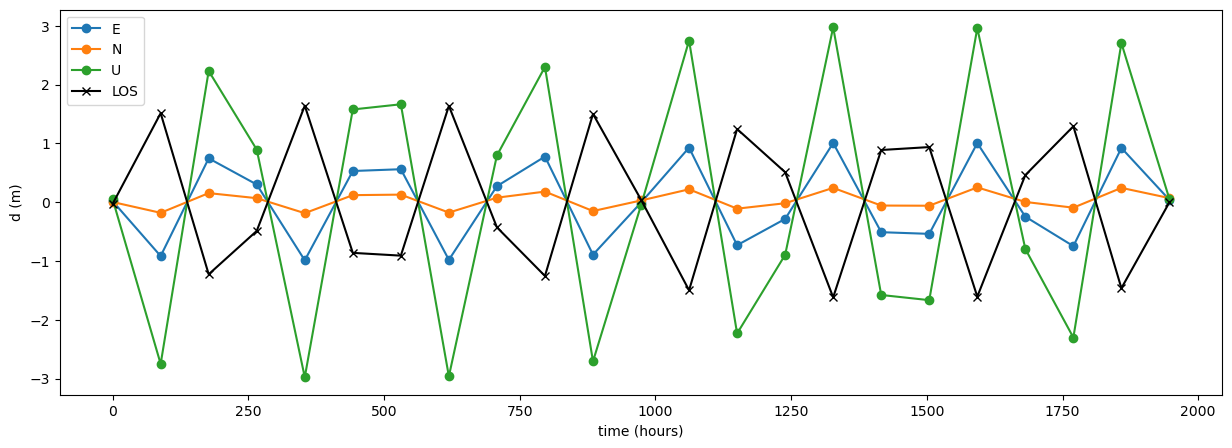

In [39]:
# specify time of acquisitions as a vector
t_duration = 2000 # in hours (1 year = 8760 hours)
t_obs = np.arange(0,t_duration,t_cycle) # in hours

# predict observations at a given site without any noise and convert to los
u_obs = u_0.reshape(-1,1) + v.reshape(-1,1)*t_obs.reshape(1,-1) + A.reshape(-1,1)*np.sin(omega*t_obs+phi).reshape(1,-1)
u_los = los_vec.reshape(1,-1) @ u_obs

# plot time series
plt.figure(figsize=(15, 5))
plt.plot(t_obs,(u_obs.T),'o-',label=['E','N','U'])
plt.plot(t_obs,(u_los.T),'kx-',label='LOS')
plt.legend()
plt.xlabel('time (hours)')
plt.ylabel('d (m)')
plt.show()

We use typical error parameters for the perpendicular baseline. The basic idea is that the baseline value will drift as a uniform random number between 0 and a maximum threshold that is set. In addition to this, there is also an error in the measurement of this baseline (from the control side of things).

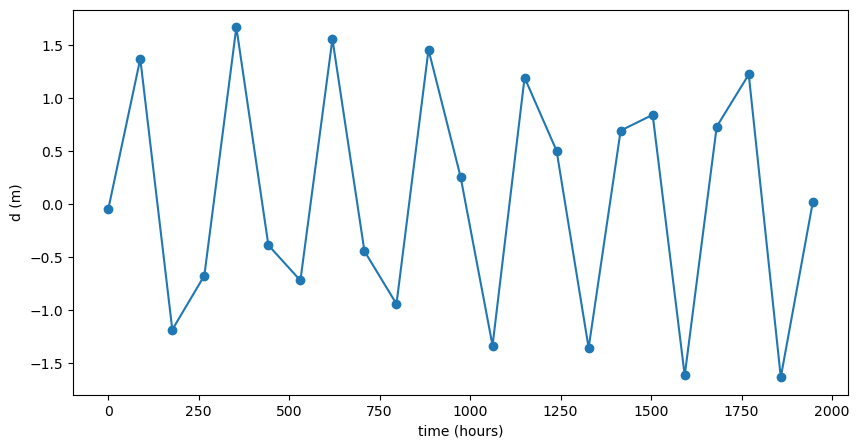

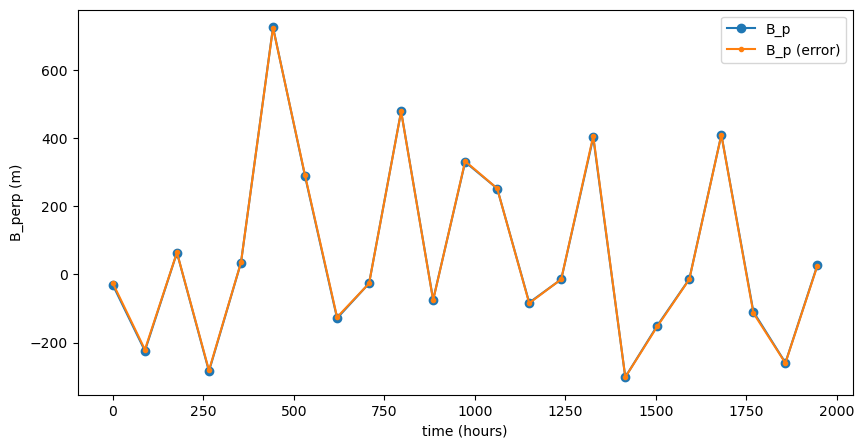

In [40]:
B_perp = np.random.normal(0,B_perp_max,[1,len(t_obs)])

# real observation
u_los_o = u_los + dh*B_perp/r_0/np.sin(theta_0)

# plot the observed los displacement time series
plt.figure(figsize=(10,5))
plt.plot(t_obs,(u_los_o.T),'o-')
plt.xlabel('time (hours)')
plt.ylabel('d (m)')
plt.show()

B_perp_model = B_perp + B_perp_error*np.random.normal(size=(1,len(t_obs)))

plt.figure(figsize=(10,5))
plt.plot(t_obs,np.transpose(B_perp),'o-',label='B_p')
plt.plot(t_obs,np.transpose(B_perp_model),'.-',label='B_p (error)')
plt.xlabel('time (hours)')
plt.ylabel('B_perp (m)')
plt.legend()
plt.show()

### Inverse problem
To estimate the model parameters in a given LOS direction i.e., $\mathbf{\hat{m}} = [v,A_1,A_2,\delta h,u_0]$ we need to first develop a model for the perpendicular baselines based on the errors that arise from the imperfect knowledge of the baseline itself. Here we guess that the error is fixed at $\epsilon_{B_p} = 2$ m.

$A_1,A_2$ comes from the decomposition of $A\sin(\omega t + \phi) = A_1\sin(\omega t) + A_2\cos(\omega t)$


The model parameters can be estimated by linear matrix inverse methods by constructing a design matrix $G$,

$$ \hat{m} = \left(G^TG\right)^{-1}u$$
the uncertainties in the model parameters are then
$$C_m = \hat{\sigma}^2\left(G^TG\right)^{-1}$$

There are two ways to estimate $\hat{\sigma}^2$, one way is to use the residuals from the best-fit predictions $\hat{\sigma}^2 = \frac{(u-G\hat{m})^T(u-G\hat{m})}{N_{dof}}$ where $N_{dof}$ is the total degrees of freedom. This term is an ad-hoc scalar estimate of the uncertainty on the data (given an associated model). However, we chose a different way - we use the volumetric decorrelation that arises from scattering of radar signals in ice, $\hat{\sigma} = 0.01$ m, as a measure of the scalar uncertainty.

In [41]:
# inverse problem

Gmat = np.concatenate([t_obs.reshape(-1,1),
                       np.sin(omega*t_obs).reshape(-1,1),
                       np.cos(omega*t_obs).reshape(-1,1),
                       np.transpose(B_perp_model)/r_0/np.sin(theta_0),
                       np.ones_like(t_obs.reshape(-1,1))],axis=1)
m_hat,*_ = np.linalg.lstsq(Gmat, u_los_o.T,rcond=None)

# uncertainties
C_m = np.linalg.inv(Gmat.T@Gmat)

# extract mean, covariance matrix associated with sinusoidal amplitudes
A_cov = sigma_hat_2*C_m[1:3,1:3]
A_mu = m_hat[1:3].flatten()
vals1,vals2 = np.random.multivariate_normal(A_mu,A_cov,1000).T
A_mag = np.sqrt(vals1**2 + vals2**2)
A_phase = np.arctan(vals2/vals1)

# plt.polar(A_phase,A_mag,'.')
# plt.show()
# print(scipy.stats.circmean(A_phase),scipy.stats.circstd(A_phase))

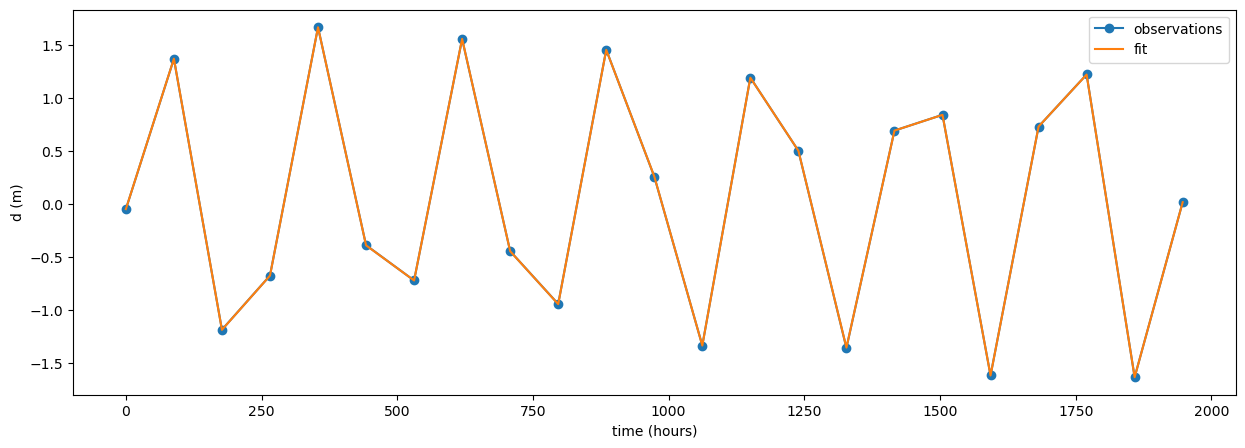

In [42]:
# plot fit to observations
plt.figure(figsize=(15, 5))
plt.plot(t_obs,u_los_o.T,'o-',label='observations')
plt.plot(t_obs,Gmat@m_hat,'-',label='fit')
plt.xlabel('time (hours)')
plt.ylabel('d (m)')
plt.legend()
plt.show()


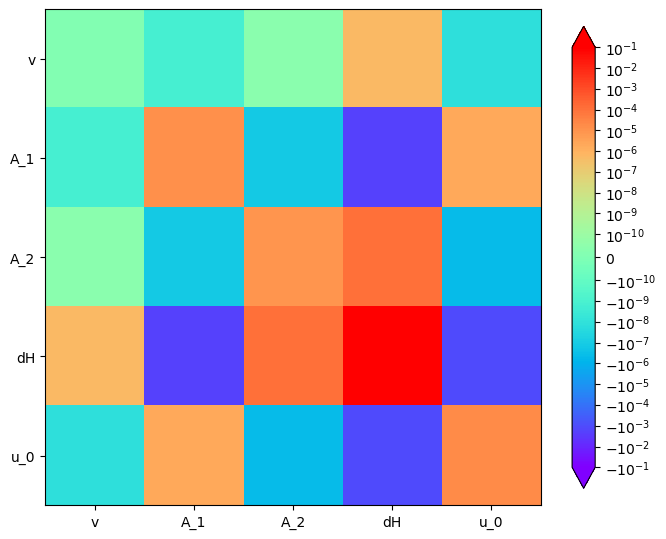

In [43]:
# compute uncertainties in model parameter estimates
res = u_los_o.T - Gmat@m_hat
# sigma_hat_2 = (res.T@res/(len(t_vec)-len(m_hat))).item()

sigma_m = np.sqrt(sigma_hat_2*np.diag(C_m))
# print(sigma_hat_2)

# plot model covariance matrix
plt.figure(figsize=(8,8))
plt.imshow(sigma_hat_2*C_m, cmap='rainbow', norm=colors.SymLogNorm(linthresh=1e-10,
                                              vmin=-.1, vmax=.1))
plt.colorbar(extend='both',shrink=0.75)
ax=plt.gca()
ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_xticklabels(["v","A_1","A_2","dH","u_0"])
ax.set_yticklabels(["v","A_1","A_2","dH","u_0"])
plt.show()

In [44]:
# # plot comparison with true parameters

# fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# axs = axs.ravel()

# # Plot the first data series on the first subplot
# axs[0].plot(1, los_vec.reshape(1,-1)@v*365*24*100, 'ko',label='true')
# axs[0].errorbar(1, m_hat[0]*365*24*100,yerr = 100*365*24*sigma_m[0],fmt='rx',label='estimated')
# axs[0].legend()
# axs[0].set_ylabel('v (cm/yr)')
# axs[1].plot(1, los_vec.reshape(1,-1)@A, 'ko',label='A_1')
# axs[1].errorbar(1, m_hat[1],yerr = sigma_m[1],fmt='rx')
# axs[1].plot(2, 0, 'ko',label='A_2')
# axs[1].errorbar(2, m_hat[2],yerr = sigma_m[2],fmt='rx')
# axs[1].set_ylabel('Amplitude of sinusoids (m)')
# axs[1].legend()
# axs[2].plot(1, dh, 'ko')
# axs[2].errorbar(1, m_hat[3],yerr = sigma_m[3],fmt='rx')
# axs[2].set_ylabel('DEM error (m)')
# axs[3].plot(1, los_vec.reshape(1,-1)@u_0, 'ko')
# axs[3].errorbar(1, m_hat[4],yerr = sigma_m[4],fmt='rx')
# axs[3].set_ylabel('u_0 (m)')

# # Show the figure
# plt.show()


## Variable observation window and certainty of estimated parameters
In this section I answer the question - how much data is needed to know the model parameters to a specified precision level, given the knowledge we have about the sources of noise/error?


In [45]:
t_obs =  np.arange(0,duration_max,t_cycle) # in hours
B_perp = np.random.normal(0,B_perp_max,[1,len(t_obs)])
B_perp_model = B_perp + B_perp_error*np.random.normal(size=(1,len(t_obs)))

# predict observations at a given site and convert to los
u_obs = u_0.reshape(-1,1) + v.reshape(-1,1)*t_obs.reshape(1,-1) + A.reshape(-1,1)*np.sin(omega*t_obs+phi).reshape(1,-1)
u_los = los_vec.reshape(1,-1) @ u_obs               
u_los_o = u_los + dh*B_perp/r_0/np.sin(theta_0)
            

Here I define the observation time window as a systematically varied parameter, and then estimate the model parameters as before :

In [46]:
t_duration_vec = np.arange(duration_min,duration_max,duration_steps) # in hours 

param_mu = np.zeros((len(m_hat),len(t_duration_vec)))
param_sigma = np.zeros((len(m_hat),len(t_duration_vec)))

A_mean = np.zeros((2,len(t_duration_vec)))
A_sigma = np.zeros((2,len(t_duration_vec)))

for i in range(0,len(t_duration_vec)):
    tindex = t_obs<t_duration_vec[i]
    t_vec = t_obs[tindex]
    u_vec = u_los_o[0,tindex]
    
    B_perp_model_vec = B_perp_model[0,tindex]
    
    Gmat = np.concatenate([t_vec.reshape(-1,1),
                           np.sin(omega*t_vec).reshape(-1,1),
                           np.cos(omega*t_vec).reshape(-1,1),
                           B_perp_model_vec.reshape(-1,1)/r_0/np.sin(theta_0),
                           np.ones_like(t_vec.reshape(-1,1))],axis=1)
    
    m_hat,*_ = np.linalg.lstsq(Gmat, u_vec.reshape(-1,1),rcond=None)
    # uncertainties
    C_m = np.linalg.inv(Gmat.T@Gmat)
    
    # res = u_vec.reshape(-1,1) - Gmat@m_hat
    A_cov = sigma_hat_2*C_m[1:3,1:3]
    A_mu = m_hat[1:3].flatten()
    vals1,vals2 = np.random.multivariate_normal(A_mu,A_cov,1000).T
    A_mag = np.sqrt(vals1**2 + vals2**2)
    A_phase = np.arctan(vals2/vals1)

    A_mean[0,i] = A_mag.mean()
    A_mean[1,i] = scipy.stats.circmean(A_phase)
    A_sigma[0,i] = A_mag.std()
    A_sigma[1,i] = scipy.stats.circstd(A_phase)

    sigma_m = np.sqrt(sigma_hat_2*np.diag(C_m))
    
    param_mu[:,i] = m_hat.T
    param_sigma[:,i] = sigma_m

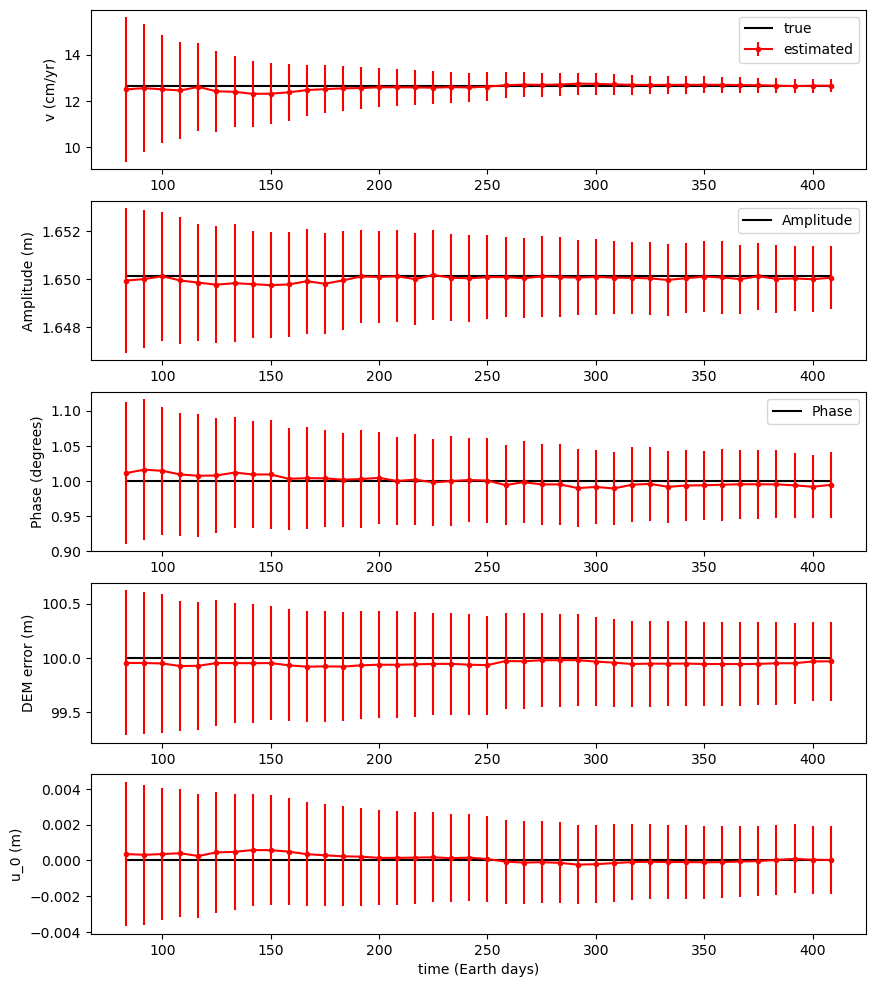

In [48]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12))

axs = axs.ravel()

toplot = los_vec.reshape(1,-1)@v*365*24*100
axs[0].plot(t_duration_vec/24, toplot*np.ones_like(t_duration_vec), 'k-',label='true')
axs[0].errorbar(t_duration_vec/24, param_mu[0,:]*365*24*100,yerr = 100*365*24*param_sigma[0,:],fmt='r.-',label='estimated')
axs[0].legend()
axs[0].set_ylabel('v (cm/yr)')

toplot = los_vec.reshape(1,-1)@A
axs[1].plot(t_duration_vec/24, abs(toplot)*np.ones_like(t_duration_vec), 'k-',label='Amplitude')
# axs[1].errorbar(t_duration_vec/24, param_mu[1,:],yerr = param_sigma[1,:],fmt='r.-')
axs[1].errorbar(t_duration_vec/24, A_mean[0,:],yerr = A_sigma[0,:],fmt='r.-')
axs[1].set_ylabel('Amplitude (m)')
axs[1].legend()

toplot = np.rad2deg(phi)
axs[2].plot(t_duration_vec/24, toplot*np.ones_like(t_duration_vec), 'k-',label='Phase')
# axs[2].errorbar(t_duration_vec/24, param_mu[2,:],yerr = param_sigma[2,:],fmt='r.-')
axs[2].errorbar(t_duration_vec/24, np.rad2deg(A_mean[1,:]),yerr = np.rad2deg(A_sigma[1,:]),fmt='r.-')
axs[2].set_ylabel('Phase (degrees)')
axs[2].legend()

axs[3].plot(t_duration_vec/24, dh*np.ones_like(t_duration_vec), 'k-')
axs[3].errorbar(t_duration_vec/24, param_mu[3,:],yerr = param_sigma[3,:],fmt='r.-')
axs[3].set_ylabel('DEM error (m)')

toplot = los_vec.reshape(1,-1)@u_0
axs[4].plot(t_duration_vec/24, toplot*np.ones_like(t_duration_vec), 'k-')
axs[4].errorbar(t_duration_vec/24, param_mu[4,:],yerr = param_sigma[4,:],fmt='r.-')
axs[4].set_ylabel('u_0 (m)')
axs[4].set_xlabel('time (Earth days)')

plt.show()